<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Decision Trees and Ensemble methods

---

## What is a Random Forest?

---

Random Forests are some of the most widespread classifiers used. They are relatively simple to use because they require very few parameters to set and they perform well. As we have seen, Decision Trees are very powerful machine learning models.

Decision Trees have some critical limitations. In particular, trees that are grown very deep tend to learn highly irregular patterns: they overfit their training sets. Bagging helps mitigate this problem by exposing different trees to different sub-samples of the whole training set.

Random forests are a further way of averaging multiple deep decision trees, trained on different parts of the same training set, with the goal of reducing the variance. This comes at the expense of a small increase in the bias and some loss of interpretability, but generally greatly boosts the performance of the final model.

### Feature bagging

Random forests differ from bagging decision trees in only one way: they use a modified tree learning algorithm that selects, at each candidate split in the learning process, a random subset of the features. This process is sometimes called feature bagging. 

The reason for doing this is due to correlation of trees in an ordinary bootstrap sample: if one or a few features are very strong predictors for the response variable (target output), these features will be selected in many of the bagging base trees, causing them to become correlated. By selecting a random subset of the features at each split, we avoid this correlation between base trees, strengthening the overall model.

#### For a problem with p features, it is typical to use:
- $p^{1/2}$ (rounded down) features in each split for a classification problem.
- $p/3$ (rounded down) with a minimum node size of 5 as the default for a regression problem.


#### Sklearn implementation
- [Sklearn Random Forest Regressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)
- [Sklearn Random Forest Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score

### 1. Load the Boston housing data set

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()
print((boston.data.shape))

(506, 13)


In [3]:
list(boston.keys())

['data', 'target', 'feature_names', 'DESCR']

In [4]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [5]:
X = pd.DataFrame(boston['data'],columns=boston.feature_names)
y = pd.Series(boston.target,name='MEDV')

In [6]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [7]:
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


### 2. Split into train and test sets and rescale the data with the standard scaler 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)



In [9]:
from sklearn.preprocessing import StandardScaler

# initialize the Scaler
ss = StandardScaler()

Xstd_train = ss.fit_transform(X_train)
Xstd_test = ss.transform(X_test)

### 3. Fit the data using a decision tree regressor on the training data and obtain mean squared and r2 error for the test set for a maximal tree depth of three.

In [10]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [11]:
dt = DecisionTreeRegressor(max_depth=3)
dt.fit(X_train, y_train)
print('score', dt.score(X_test, y_test))
print('R2_mean', cross_val_score(dt, X_test, y_test).mean() )

score 0.7759762863738834
R2_mean 0.49801630543588


### 4. Visualise the corresponding decision tree

In [12]:
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image 

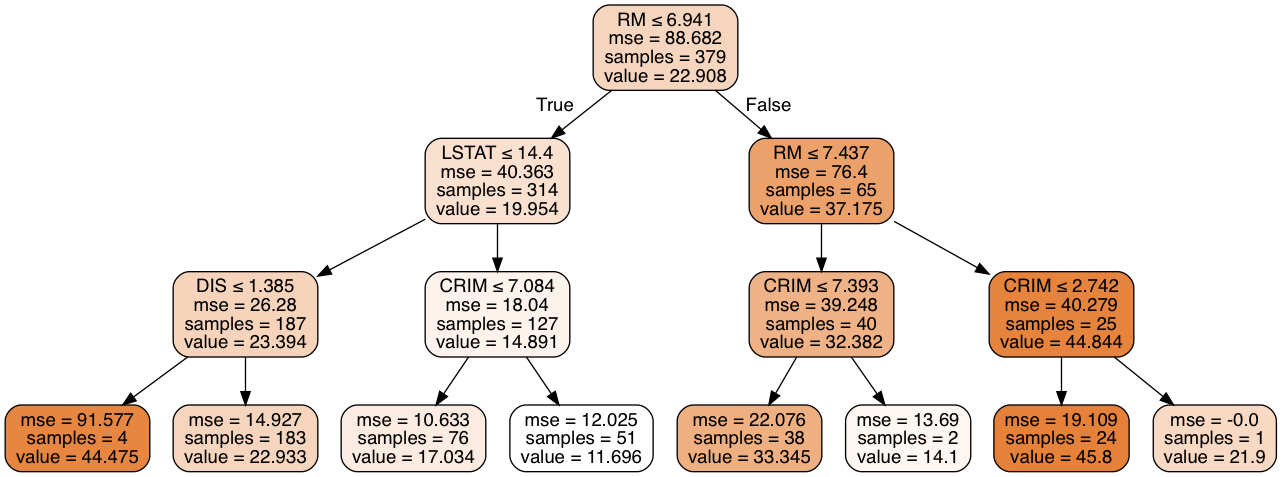

In [13]:
dot_data = StringIO()  

export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X.columns)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### 5. Perform grid search varying the maximal tree depth, the maximal number of leaf nodes and the minimal number of samples in the leafs. Determine the best model using once the default R2 scoring and once 'neg_mean_squared_error' and compare.

In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict

In [49]:
param_grid = {'max_depth': np.arange(3, 10),
             'max_leaf_nodes': [10],
              'min_samples_leaf': np.arange(1, 10)
             }

In [50]:
DecisionTree_gridsearch = GridSearchCV(DecisionTreeRegressor(), 
                              param_grid)

DecisionTree_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([3, 4, 5, 6, 7, 8, 9]), 'max_leaf_nodes': [10], 'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [53]:
best_est = DecisionTree_gridsearch.best_estimator_
best_est

DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
           max_leaf_nodes=10, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [57]:
best_est.fit(X_train, y_train)
print('score', best_est.score(X_test, y_test))
print('R2_mean', cross_val_score(best_est, X_test, y_test).mean() )

score 0.8060714438661933
R2_mean 0.4956577457504318


In [60]:
predicat = cross_val_predict(best_est, X_test, y_test)
print('neg_mean_squared_error', mean_squared_error(y_test, predicat) )

neg_mean_squared_error 34.84310640889687


### 6. Now use ensemble methods to fit decision trees. For BaggingRegressor and RandomForestRegressor, vary the number of estimators (n_estimators). Use cross_val_score with five-fold cross validation and scoring 'neg_mean_squared_error'. Plot how the mean of the scoring changes.

In [84]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

In [62]:
Bagging = BaggingRegressor(best_est, random_state=42)

In [78]:
print('R2_mean', cross_val_score(Bagging, X_test, y_test).mean() )
Bagging.fit(X_train, y_train)
print('score', Bagging.score(X_test, y_test))

R2_mean 0.5781790415179816
score 0.7893060059845469


In [79]:
predicat_Bag = cross_val_predict(Bagging, X_test, y_test)
print('neg_mean_squared_error', mean_squared_error(y_test, predicat) )

neg_mean_squared_error 34.84310640889687


In [85]:
clf = RandomForestRegressor(n_estimators=100, max_depth=2, random_state=42)

In [86]:
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [87]:
print('score', clf.score(X_test, y_test))
print('R2_mean', cross_val_score(clf, X_test, y_test).mean() )

score 0.7050401107097639
R2_mean 0.5782266270101527


In [88]:
predicat_Ran = cross_val_predict(clf, X_test, y_test)
print('neg_mean_squared_error', mean_squared_error(y_test, predicat) )

neg_mean_squared_error 34.84310640889687


In [89]:
import matplotlib.pyplot as plt

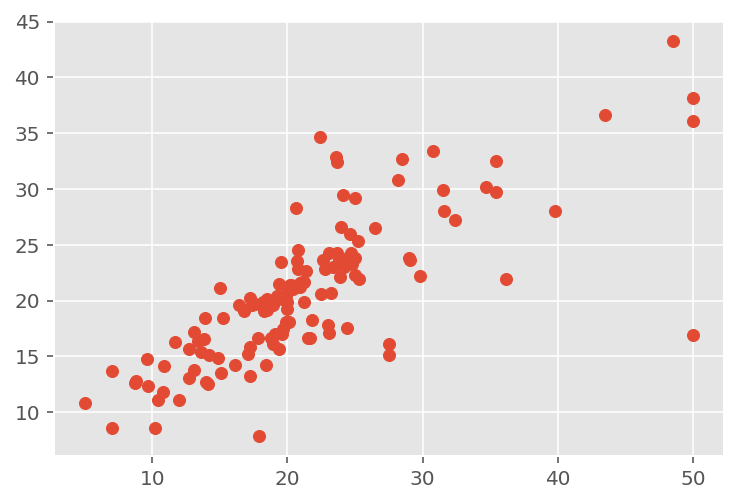

In [99]:
plt.scatter(y_test, predicat_Bag)
plt.show()

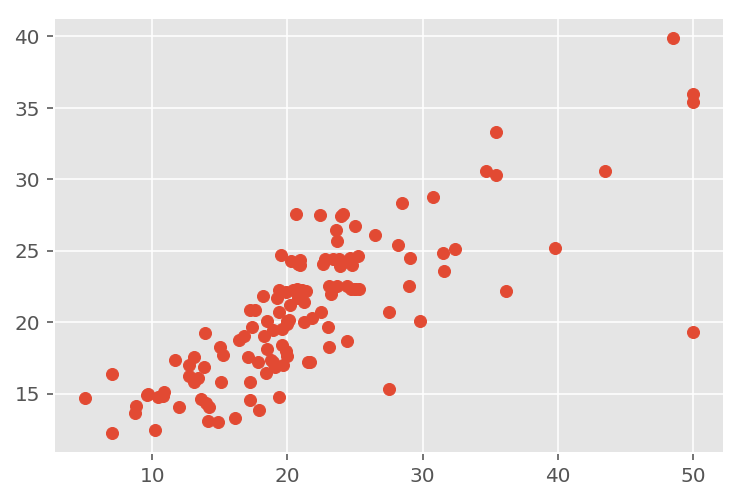

In [100]:
plt.scatter(y_test, predicat_Ran)
plt.show()

### Bonus: Vary further parameters and describe the impact on the model score.